## Let's demo RivGraph on the Brahmaputra River!
This demo shows some of the core functionality and convenient plotting and exporting features provided by RivGraph. The basic steps of RivGraph-ing a braided river include: 
1. Instantiate river class 
2. Skeletonize the binary mask 
3. Compute the network (links and nodes) 
4. Prune the network 
5. Compute morphologic metrics (lengths, widths)
6. Compute a mesh (6.1 - Adjust mesh parameters) 
7. Assign flow directions for each link
8. A note on topologic metrics

Along the way, we'll export some geotiffs and GeoJSONs (or shapefiles if you prefer) for inspection in QGIS. RivGraph requires a **binary mask of the channel network**, preferably georeferenced (i.e., a GeoTiff) in a projected coordinate reference system.

### 1. Instantiate river class

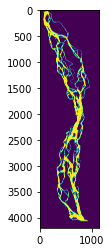

In [1]:
from rivgraph.classes import river
import matplotlib.pyplot as plt
import os

# Define the path to the georeferenced binary image.
mask_path = './data/Brahmaputra_Braided_River/Brahmaputra_mask.tif'

# Results will be saved with this name
name = 'Brahma' 

# Where to store RivGraph-generated geotiff and geovector files.
results_folder = './data/Brahmaputra_Braided_River/Results' 

# Set the exit sides of the river relative to the image. In this case, the
# Brahmaputra is "entering" the image from the North and "exiting" the 
# image from the South.
es = 'NS' # The first character is the upstream side

# Boot up the river class! We set verbose=True to see progress of processing.
brahma = river(name, mask_path, results_folder, exit_sides=es, verbose=True) 

# The mask has been re-binarized and stored as an attribute of brahma:
plt.imshow(brahma.Imask)

### 2. Skeletonize the binary mask

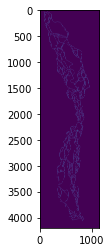

In [2]:
# Simply use the skeletonize() method.
brahma.skeletonize()

# The skeletonized image is stored as an attribute to the brahm class. Let's take a look.
plt.imshow(brahma.Iskel)

In [3]:
# The skeleton is hard to see; perhaps we'd like to look at it closer?
# One option is to save it as a geotiff and pull it up in a GIS (like QGIS).
# We use the write_geotiff() method with the 'skeleton' option.
brahma.to_geotiff('skeleton')

Geotiff written to data\Brahmaputra_Braided_River\Results\Brahma_skel.tif.


The georeferenced Brahmaputra skeleton has been written to disk, so we can pull it up in QGIS along with the georeferenced mask:

![brahma_qgis_mask_skel.PNG](images/brahma_qgis_mask_skel.png)


### 3. Compute the network (links and nodes)

In [4]:
# Simply use the compute_network() method.
brahma.compute_network()

Resolving links and nodes...done.


In [5]:
# Now we can see that the "links" and "nodes" dictionaries ahve been added 
# as attributes to the brahma class:
links = brahma.links
nodes = brahma.nodes
print('links: {}'.format(links.keys()))
print('nodes: {}'.format(nodes.keys()))

links: dict_keys(['idx', 'conn', 'id', 'n_networks'])
nodes: dict_keys(['idx', 'conn', 'id'])


The *links* dictionary currently contains four keys: 
-  <i>idx</i>: a list of all the pixel indices that make up the link (indices created with input mask shape and np.ravel_multi_index)
- <i>conn</i> : a two-element list containing the node *id*s of the link's endpoints
- <i>id</i>: each link has a unique *id*; the ordering is irrelevant
- <i>n_networks</i>: the number of disconnected networks (==1 if the input mask contains a single connected blob)
    
The *nodes* dictionary currently contains three keys:
- <i>idx</i>: the index of the node's position within the original image (i.e. np.ravel_multi_index())
- <i>conn</i>: an N-element list containing the N link *id*s of the links connected to this node.
- <i>id</i>: each node has a unique *id*; the ordering is irrelevant
    
We can visualze the network in a couple of ways. First, we can plot with matplotlib:

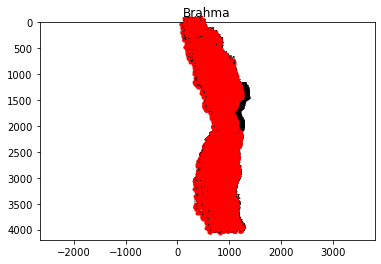

In [6]:
brahma.plot('network')

Nodes and links are labeled with their ids. We can zoom in if plotting in an interactive matplotlib window, *or* we can export the network links and nodes as geovector files and pull 'em into QGIS:

In [7]:
brahma.to_geovectors('network', ftype='json')

# Let's see where the network geovector files were written:
print(brahma.paths['links'])
print(brahma.paths['nodes'])

data\Brahmaputra_Braided_River\Results\Brahma_links.json
data\Brahmaputra_Braided_River\Results\Brahma_nodes.json


And dragging these into QGIS:
![brahma_qgis_network_unpruned.PNG](images/brahma_qgis_network_unpruned.png)
You can query different links and nodes using the Identify tool. Note that their properties ('conn' and 'id') are appended.

If you pan around a bit,  you'll notice that there are many "dangling" links, or links connected only at one end. These links play no role in the connectivity of the network, and we therefore may want to remove them. We don't want to remove the inlet and outlet links, however. RivGraph will prune these dangling links but preserve the inlet and outlet links by exploiting the *exit_sides* we supplied earlier. Let's prune the network.

### 4. Prune the network

In [8]:
brahma.prune_network()

# We see that 'inlets' and 'outlets' have been added to the nodes dictionary:
print(brahma.nodes.keys())

# We can get the node ids of the inlets and outlets
print('inlets:', brahma.nodes['inlets'])
print('outlets:', brahma.nodes['outlets'])

dict_keys(['idx', 'conn', 'id', 'inlets', 'outlets'])
inlets: [247]
outlets: [1919]


### 5. Compute morphologic metrics (lengths, widths)
Now that the network is resolved and pruned, we can compute some link metrics.

Computing distance transform...done.
Computing link widths and lengths...done.


Text(0.5, 1.0, 'Histogram of link lengths')

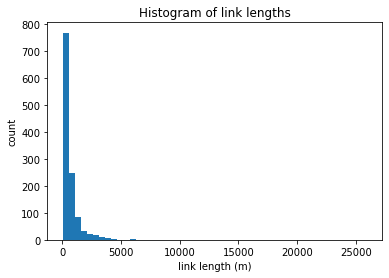

In [9]:
brahma.compute_link_width_and_length()

# Let's look at histograms of link widths and lengths:
trash = plt.hist(brahma.links['len_adj'], bins=50)
plt.ylabel('count')
plt.xlabel('link length (m)')
plt.title('Histogram of link lengths')

In the above figure, we see that almost all the links are shorter than 5 km. This histogram will be different for each braided river, and can depend on the resolution of your input binary mask. Resolving smaller channels generally, though not always, produces smaller average link lengths as longer links are broken to connect to the smaller ones.

**Note**: the lengths are reported in **meters** bcause that is the unit of the provided mask's CRS (coordinate reference system). You can check this unit:

In [10]:
print(brahma.unit)

meter


### 5. Compute a mesh
In preparation for setting flow directions of each link, we will compute an "along-valley" mesh. This mesh is created based on the overall morphology of the braided river as opposed to individual channels within the network. The objective of the mesh is to create an along-channel grid that contains transects that are roughly perpendicular to the river "centerline" and approximately evenly-spaced. 

While this mesh is necessary for setting flow directions, it is also useful for measuring along-river characteristics (like width, erosion rates, braiding index, etc.). The generation of this mesh requires a few parameters that ideally would be user-defined each time. However, for simplicity, RivGraph will make estimates of these parameters based primarily off the average link width. These parameters are described after we generate a default mesh.

In [11]:
# Note that we provide no arguments to the compute_mesh() function.
brahma.compute_mesh()

Computing centerline...done.
Computing link widths and lengths...done.
Generating mesh...done.


Before we play with the mesh-generation parameters, let's take a look at what we've generated with the ```compute_mesh()``` function. 

First, we see that a centerline was computed. We can access this centerline:

In [12]:
print(brahma.centerline)

(array([764625., 764595., 764565., ..., 785475., 785505., 785535.]), array([2753535., 2753505., 2753475., ..., 2633625., 2633655., 2633655.]))


We get a numpy array of two arrays of columns, rows of the centerline. This isn't very interpretable as-is, but we can export the centerline as a geovector file:

In [13]:
brahma.to_geovectors('centerline', ftype='json')

The centerline is exported as a shapefile or GeoJSON, depending on the filetype you specify. (GeoJSON is default.) Let's take a look at this centerline in QGIS:

![brahma_qgis_centerline.png](images/brahma_qgis_centerline.png)

A little jagged, but it's fine for our purposes. The centerline is computed by filling in all the islands of the network, then using a distance transform to find the "centermost" pixels. 

Now let's take a look at the mesh we generated. We first need to export it:


In [14]:
brahma.to_geovectors('mesh', ftype='json')

The mesh consists of two files: ```meshlines```, or transects, and ```meshpolys```. If we want to see where these files were generated, we can check the paths dictionary:

In [15]:
print(brahma.paths['meshlines'])
print(brahma.paths['meshpolys'])

data\Brahmaputra_Braided_River\Results\Brahma_meshlines.json
data\Brahmaputra_Braided_River\Results\Brahma_meshpolys.json


Let's see what the mesh looks like by dragging these GeoJSONs into QGIS:

![brahma_qgis_initial_meshlines.png](images/brahma_qgis_initial_meshlines.png)

The mesh does a pretty good job of meeting our two criteria: approximately perpendicular to the centerline, and evenly-spaced along the centerline. It's not perfect, but we can play with the parameters to adjust it.

### 5.1 Adjust mesh parameters

We may want to alter certain features of the mesh, like the spacing of transects or the overall width of the mesh. When we call ```compute_mesh()```, there are three optional keyword arguments we can provide to control mesh properties. These are:

```grid_spacing``` : The along-centerline distance between each transect. The default value is the average link width, found by ```np.mean(brahm.links['wid_adj'])```.

```smoothing``` : The degree of smoothing to perform on the centerline before creating its offsets. This parameter is expressed in terms of the fraction of the total centerline length, so the default ```smoothing=0.1``` will use a moving-average with a window size of 10% of the length of the centerline.

```buf_halfwidth``` : The distance from the centerline to each edgeline of the buffer. The default is 10% wider than the maximum width of the mask, which ensures that the mask is fully covered by the mesh. 

We can check what values of each of these were used above:

In [16]:
# grid_spacing
print('grid_spacing: {}'.format(brahma.avg_chan_width))
# buf_halfwidth
print('buf_halfwidth: {}'.format(brahma.max_valley_width_pixels * brahma.pixlen * 1.1))
# smoothing by default was 0.1
print('smoothing: {}'.format(0.1))


grid_spacing: 623.1819853141467
buf_halfwidth: 15631.83213830036
smoothing: 0.1


You may have noticed that the mesh transects near the beginning of the reach (top of image) aren't quite a perpendicular to the centerline as we might like. Let's try smoothing the centerline a bit more and reducing the buffer width to make these more perpendicular. The grid spacing will not affect the overall mesh strucutre, so we'll leave it the same for comparison purposes.

In [17]:
brahma.compute_mesh(buf_halfwidth=10000, smoothing=0.25)

Generating mesh...done.


Here's a side-by-side comparison with the default mesh:

![brahma_mesh_comparison.png](images/brahma_mesh_comparison.png)

There are two primary differences between our custom mesh and the default one. First, the custom mesh is narrower as a direct result of us reducing ```buf_halfwidth``` from 15631 to 10000. Secondly, the custom mesh transects are significantly more parallel to the centerline than the default mesh. This resulted from increasing ```smoothing``` from 0.1 to 0.25. These two parameters, plus ```grid_spacing```, can be used to design a mesh to suit your needs. 


### 7. Assign flow directions to each link
Now we want to determine the long-term, steady-state flow direction in each link. The algorithms used here are described in [this paper](https://www.earth-surf-dynam.net/8/87/2020/esurf-8-87-2020.html).

In [18]:
brahma.assign_flow_directions()

Setting link directionality...A file has been created for manually setting link directions at data\Brahmaputra_Braided_River\Results\Brahma_fixlinks.csv.
Attempting to fix 2 cycles.
All cycles were resolved.
done.


A statement appears that tells us that a .csv file was created for us to set flow directions manually. This file is only created if it does not already exist. So if we re-run ```assign_flow_directions()```, we should not see this message again.

In [20]:
brahma.assign_flow_directions()

Setting link directionality...Using data\Brahmaputra_Braided_River\Results\Brahma_fixlinks.csv to manually set flow directions.
Attempting to fix 2 cycles.
All cycles were resolved.
done.


Now we see a message stating that RivGraph will use the .csv file to set flow directions manually. However, we haven't populated the file yet so no there is no information for RivGraph to use. We'll revisit this at the end of this section.

We also see a message stating that RivGraph is ```Attempting to fix 2 cycles.``` A cycle is a set of links within a graph that feeds into itself. RivGraph's directionality algorithms enforce the condition that no cycles should be present in the resulting graph. If any cycles are found after setting all link directions, RivGraph attempts to fix them. This does not mean that all the links' directions are correct, but rather that the resulting graph contains no cycles. In this case, RivGraph was able to resolve both cycles.

Let's inspect the resulting link directions. We again have two options: we can plot the links via matplotlib within Python:

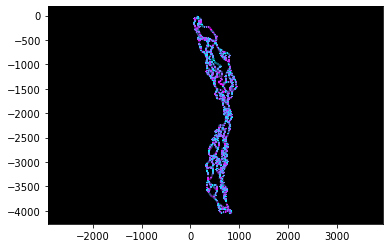

In [21]:
brahma.plot('directions')

Cyan represents the upstream portion of a link, and magenta the downstream. As before, this is difficult to see without zoooming. So we can export a geotiff that contains directionality information for inspection in QGIS:

In [23]:
brahma.to_geotiff('directions')

Geotiff written to data\Brahmaputra_Braided_River\Results\Brahma_link_directions.tif.


Dragging into QGIS (and adding a colorbar legend), we see

![brahma_qgis_initial_directions.png](images/brahma_qgis_initial_directions.png)

I've circled two short links in yellow, and noted that their flow direction was set as going right-to-left. Ideally, this junction would be comprised of a single node replacing these links, but RivGraph does not have the capability yet to simplify the network ([a feature request has been made for this)](https://github.com/jonschwenk/RivGraph/issues/11). From cursory inspection, we could make the argument that flow should instead go left-to-right for these two links. Let's force flow the opposite direction as an example of how to manually set links.

First, we need to identify the link ID's of each of these links, as well as the desired upstream nodes. Using the Identify tool in QGIS with the links and nodes GeoJSON layers turned on, this is easy:

![brahma_qgis_identify_links_for_reversal.png](images/brahma_qgis_identify_links_for_reversal.png)

We see that the red-highlighted link's ID is ```2280```, and it's (upstream, downstream) nodes are ```1631, 1650```. We want to reverse this order so that the upstream node ID is ```1650```. Open the ```Brahma_fixlinks``` csv and enter this information. I have also done this for the link to the right of this one.

![brahma_fixlinks_csv.png](images/brahma_fixlinks_csv.png)

Simply save the .csv and re-run the ```assign_flow_directions()``` method:



In [24]:
brahma.assign_flow_directions()

Setting link directionality...Using data\Brahmaputra_Braided_River\Results\Brahma_fixlinks.csv to manually set flow directions.
Attempting to fix 2 cycles.
All cycles were resolved.
done.


After exporting the ```directions``` geotiff again, we can plot it against the original:

![brahma_flow_direction_reversed_manually.png](images/brahma_flow_direction_reversed_manually.png)

We see that RivGraph used the information in our .csv to manually set the flow directions for both these links in the opposite direction of the original solution. It is important to note that RivGraph guarantees that whatever link flow directions are specified in the .csv will be preserved throughout the direction-setting process. RivGraph uses an iterative approach to set link directionalities, where knowing the direction of a nearby link can be used to set links of unknown directions. This means that if you incorrectly set a link's direction manually, you could "infect" the nearby links with wrong directions! Indeed, we see from the above comparison that the upper-right link's direction has also been reversed, even though we didn't specify it. Whether or not this is correct is determined by the user.



### 8. A note on topologic metrics
If you've looked through the [delta example](https://github.com/jonschwenk/RivGraph/blob/master/examples/delta_example.ipynb), you'll see the final section covers computing topolgic metrics. In order to compute these metrics, some additional finagling of the network is required. We have not yet implemented the required pre-processing for braided rivers. However, many of the functions in the [delta metrics script](https://github.com/jonschwenk/RivGraph/blob/master/rivgraph/deltas/delta_metrics.py) can be used on braided rivers, provided you first pre-process your braided river network properly.